In [1]:
import pandas as pd
import numpy as np
import re
import string
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Flatten, Concatenate, Dropout

2024-09-03 03:24:39.189261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 03:24:39.189393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 03:24:39.331210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df=pd.read_csv("/kaggle/input/finaldata/cleanedDataset.csv")

In [3]:
df

,Thought,Label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,length_of_Thought
0,everyon probabl mad,negative,3,3,0,0,6.333333,21,0,0,0,21
1,braver believ,positive,2,2,0,0,6.500000,14,0,0,0,14
2,open eye want see,positive,4,4,0,0,3.750000,18,0,0,0,18
3,clearli dont want friend anymor,negative,5,5,0,0,5.800000,33,0,0,0,33
4,never done befor,negative,3,3,1,0,5.000000,17,0,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...
156780,believ fast time fli,negative,4,4,0,0,5.000000,23,0,0,0,23
156781,eat spici food,negative,3,3,0,0,4.000000,14,0,0,0,14
156782,itâ OK screw Up nigel raw,positive,6,6,1,0,3.500000,26,0,0,0,26
156783,itâ here itâ beauti itâ sign fit right in,positive,9,7,2,0,4.666667,50,0,0,0,50


In [4]:
df = df[['Thought', 'Label']]

In [5]:
df

,Thought,Label
0,everyon probabl mad,negative
1,braver believ,positive
2,open eye want see,positive
3,clearli dont want friend anymor,negative
4,never done befor,negative
...,...,...
156780,believ fast time fli,negative
156781,eat spici food,negative
156782,itâ OK screw Up nigel raw,positive
156783,itâ here itâ beauti itâ sign fit right in,positive


In [6]:
nan_counts_per_column = df.isna().sum()
print("NaN counts per column:")
print(nan_counts_per_column)

NaN counts per column:
Thought    79
Label       0
dtype: int64


In [7]:
# Count total NaN values in the entire DataFrame
total_nan_count = df.isna().sum().sum()
print("\nTotal NaN values in the DataFrame:")
print(total_nan_count)


Total NaN values in the DataFrame:
79


In [8]:
df = df.dropna()

In [9]:
# Count total NaN values in the entire DataFrame
df['Thought'] = df['Thought'].str.lower()
total_nan_count = df.isna().sum().sum()
print("\nTotal NaN values in the DataFrame:")
print(total_nan_count)
df


Total NaN values in the DataFrame:
0


/tmp/ipykernel_34/881237108.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Thought'] = df['Thought'].str.lower()


,Thought,Label
0,everyon probabl mad,negative
1,braver believ,positive
2,open eye want see,positive
3,clearli dont want friend anymor,negative
4,never done befor,negative
...,...,...
156780,believ fast time fli,negative
156781,eat spici food,negative
156782,itâ ok screw up nigel raw,positive
156783,itâ here itâ beauti itâ sign fit right in,positive


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

class TextClassificationModel:
    def __init__(self, df, max_len=600, embedding_dim=128):
        self.df = df
        self.max_len = max_len
        self.embedding_dim = embedding_dim
        self.tokenizer = Tokenizer()
        self.label_encoder = LabelEncoder()

    def preprocess_data(self, split=0.2):
        # Encode the labels
        self.df['Thought'] = self.df['Thought'].astype(str)
        self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(self.df['Thought'], self.df['Label'], test_size=split, random_state=42)

        # Tokenize the text
        self.tokenizer.fit_on_texts(X_train)
        X_train_seq = self.tokenizer.texts_to_sequences(X_train)
        X_test_seq = self.tokenizer.texts_to_sequences(X_test)

        # Pad the sequences
        X_train_pad = pad_sequences(X_train_seq, maxlen=self.max_len)
        X_test_pad = pad_sequences(X_test_seq, maxlen=self.max_len)

        return X_train_pad, X_test_pad, y_train, y_test

    def build_model(self):
        # Define the input layer
        input_layer = Input(shape=(self.max_len,))

        # Embedding layer
        embedding_layer = Embedding(input_dim=len(self.tokenizer.word_index) + 1, output_dim=self.embedding_dim)(input_layer)

        # CNN part
        conv_layer = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
        pooling_layer = GlobalMaxPooling1D()(conv_layer)

        # BiLSTM part
        bilstm_layer = Bidirectional(LSTM(128, return_sequences=False))(embedding_layer)

        # Concatenate CNN and BiLSTM outputs
        concat_layer = Concatenate()([pooling_layer, bilstm_layer]) 

        # Add Dense layers
        dense_layer = Dense(128, activation='relu')(concat_layer)
        dropout_layer = Dropout(0.6)(dense_layer)
        output_layer = Dense(1, activation='sigmoid')(dropout_layer)

        # Build the model
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        return model

    def train_model(self, model, X_train_pad, y_train, X_test_pad, y_test, epochs=10, batch_size=64):
        history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test_pad, y_test))
        return history

    def plot_history(self, history):
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate_model(self, model, X_test_pad, y_test):
        loss, accuracy = model.evaluate(X_test_pad, y_test)
        print(f'Test Accuracy: {accuracy * 100:.2f}%')
        return accuracy

    def extract_features(self, model, X_train_pad, X_test_pad):
        feature_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_5').output)
        X_train_features = feature_extractor.predict(X_train_pad)
        X_test_features = feature_extractor.predict(X_test_pad)
        return X_train_features, X_test_features

    def train_logistic_regression(self, X_train_features, y_train):
        lr_model = LogisticRegression(max_iter=1000)
        lr_model.fit(X_train_features, y_train)
        return lr_model

    def evaluate_logistic_regression(self, lr_model, X_test_features, y_test):
        y_pred = lr_model.predict(X_test_features)
        target_names = [str(cls) for cls in self.label_encoder.classes_]

        # Calculate and print the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f'Accuracy: {accuracy:.4f}')
        # Print the classification report
        print(classification_report(y_test, y_pred, target_names=target_names))


# Dropout = 0.2

/tmp/ipykernel_34/3158963982.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/3158963982.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 600, 128)  │  4,862,592 │ input_layer_12[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 596, 128)  │     82,048 │ embedding_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_12[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_12    │ (None, 256)       │    263,168 │ embedding_12[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 128)       │     49,280 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,257,217 (20.05 MB)

 Trainable params: 5,257,217 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 163s 82ms/step - accuracy: 0.8575 - loss: 0.3116 - val_accuracy: 0.9424 - val_loss: 0.1593
Epoch 2/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 160s 82ms/step - accuracy: 0.9655 - loss: 0.1012 - val_accuracy: 0.9461 - val_loss: 0.1606
Epoch 3/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 160s 82ms/step - accuracy: 0.9833 - loss: 0.0481 - val_accuracy: 0.9445 - val_loss: 0.1925
Epoch 4/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 160s 82ms/step - accuracy: 0.9894 - loss: 0.0297 - val_accuracy: 0.9479 - val_loss: 0.2194
Epoch 5/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 0.9933 - loss: 0.0190 - val_accuracy: 0.9470 - val_loss: 0.2514
Epoch 6/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 161s 82ms/step - accuracy: 0.9939 - loss: 0.0174 - val_accuracy: 0.9467 - val_loss: 0.2776
Epoch 7/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 160s 82ms/step - accuracy: 0.9953 - loss: 0.0128 - val_accuracy: 0.9429 - val_loss: 0.2447
Epoch 8/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 160s 82ms/step - accuracy: 

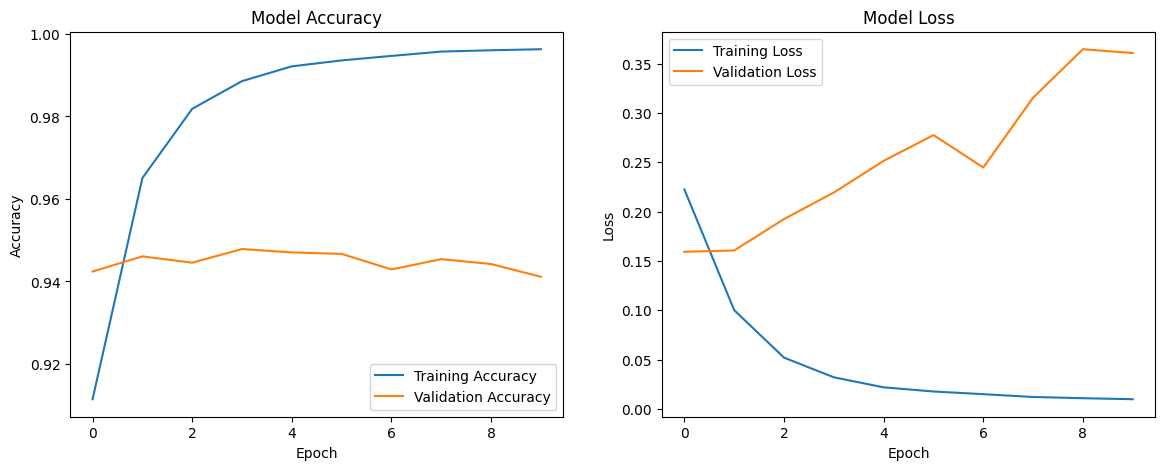

980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - accuracy: 0.9411 - loss: 0.3682
Test Accuracy: 94.11%


0.9411333203315735

In [53]:
split_ratio = 0.2

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

In [54]:
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

3918/3918 ━━━━━━━━━━━━━━━━━━━━ 109s 28ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     14237
           1       0.96      0.94      0.95     17105

    accuracy                           0.94     31342
   macro avg       0.94      0.94      0.94     31342
weighted avg       0.94      0.94      0.94     31342



# # Dropout = 0.3

/tmp/ipykernel_34/2507659073.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/2507659073.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 600, 128)  │  4,862,592 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 596, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,257,217 (20.05 MB)

 Trainable params: 5,257,217 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 170s 84ms/step - accuracy: 0.8606 - loss: 0.3049 - val_accuracy: 0.9430 - val_loss: 0.1593
Epoch 2/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - accuracy: 0.9662 - loss: 0.0967 - val_accuracy: 0.9483 - val_loss: 0.1526
Epoch 3/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - accuracy: 0.9838 - loss: 0.0472 - val_accuracy: 0.9467 - val_loss: 0.1821
Epoch 4/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - accuracy: 0.9903 - loss: 0.0289 - val_accuracy: 0.9452 - val_loss: 0.2221
Epoch 5/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - accuracy: 0.9926 - loss: 0.0198 - val_accuracy: 0.9452 - val_loss: 0.2599
Epoch 6/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 162s 83ms/step - accuracy: 0.9945 - loss: 0.0155 - val_accuracy: 0.9484 - val_loss: 0.2698
Epoch 7/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 163s 83ms/step - accuracy: 0.9956 - loss: 0.0128 - val_accuracy: 0.9470 - val_loss: 0.2971
Epoch 8/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 167s 85ms/step - accuracy: 

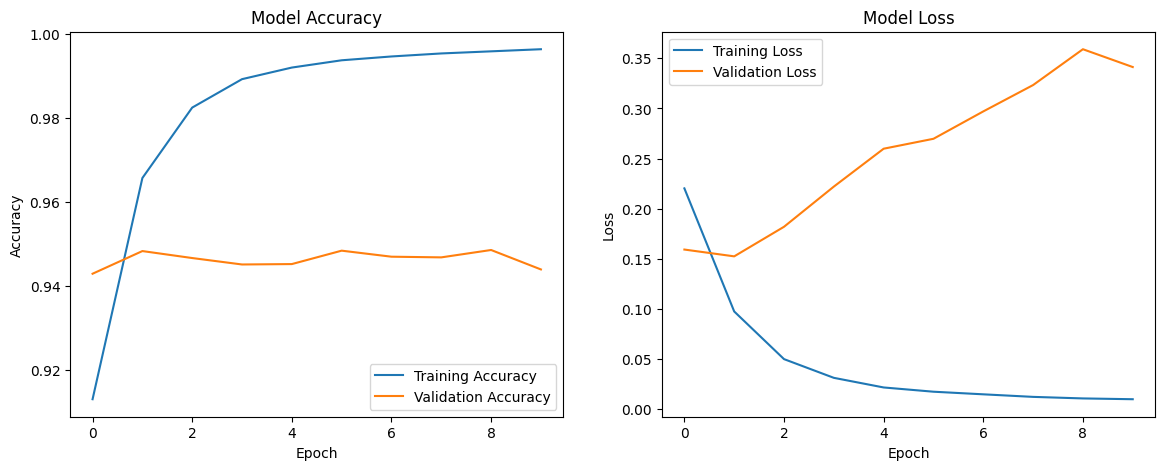

980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9428 - loss: 0.3497
Test Accuracy: 94.40%


0.9439729452133179

In [15]:
split_ratio = 0.2

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)

In [18]:
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

3918/3918 ━━━━━━━━━━━━━━━━━━━━ 114s 29ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step
Accuracy: 0.94
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94     14237
    positive       0.95      0.95      0.95     17105

    accuracy                           0.94     31342
   macro avg       0.94      0.94      0.94     31342
weighted avg       0.94      0.94      0.94     31342



# Dropout = 0.4

/tmp/ipykernel_34/3409750331.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/3409750331.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 600, 128)  │  4,862,592 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 596, 128)  │     82,048 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    263,168 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,257,217 (20.05 MB)

 Trainable params: 5,257,217 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 172s 85ms/step - accuracy: 0.8561 - loss: 0.3127 - val_accuracy: 0.9432 - val_loss: 0.1593
Epoch 2/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 165s 84ms/step - accuracy: 0.9658 - loss: 0.0982 - val_accuracy: 0.9475 - val_loss: 0.1493
Epoch 3/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9822 - loss: 0.0489 - val_accuracy: 0.9466 - val_loss: 0.1804
Epoch 4/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9903 - loss: 0.0287 - val_accuracy: 0.9463 - val_loss: 0.2138
Epoch 5/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9925 - loss: 0.0218 - val_accuracy: 0.9432 - val_loss: 0.2565
Epoch 6/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9943 - loss: 0.0166 - val_accuracy: 0.9458 - val_loss: 0.2855
Epoch 7/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9951 - loss: 0.0138 - val_accuracy: 0.9439 - val_loss: 0.3482
Epoch 8/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 

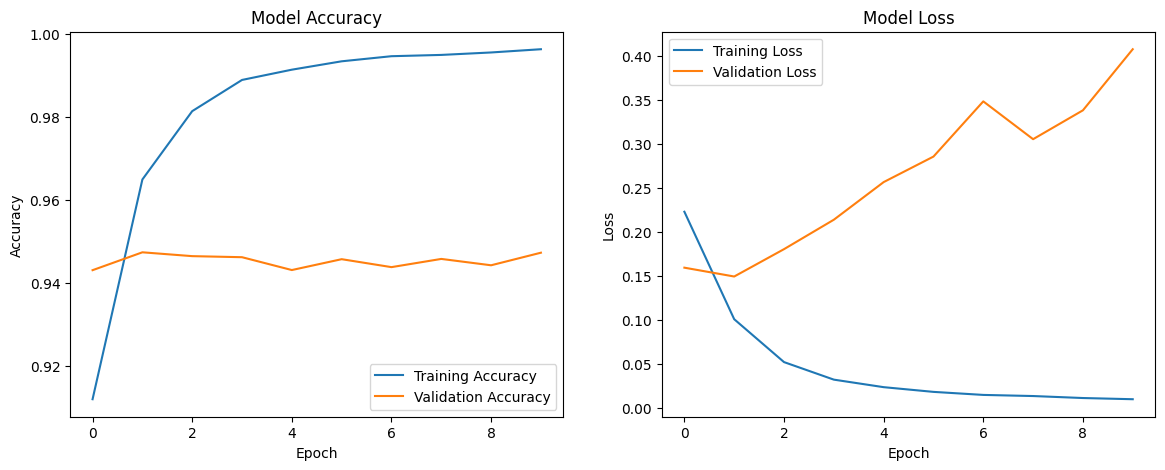

980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9466 - loss: 0.4167
Test Accuracy: 94.74%
3918/3918 ━━━━━━━━━━━━━━━━━━━━ 111s 28ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step
Accuracy: 0.9473
              precision    recall  f1-score   support

    negative       0.95      0.93      0.94     14237
    positive       0.94      0.96      0.95     17105

    accuracy                           0.95     31342
   macro avg       0.95      0.95      0.95     31342
weighted avg       0.95      0.95      0.95     31342



In [12]:
split_ratio = 0.2

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Dropout = 0.5

/tmp/ipykernel_34/2242781648.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/2242781648.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 600, 128)  │  4,862,592 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     49,280 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,257,217 (20.05 MB)

 Trainable params: 5,257,217 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 167s 84ms/step - accuracy: 0.8554 - loss: 0.3136 - val_accuracy: 0.9442 - val_loss: 0.1589
Epoch 2/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9659 - loss: 0.0978 - val_accuracy: 0.9474 - val_loss: 0.1529
Epoch 3/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9827 - loss: 0.0492 - val_accuracy: 0.9464 - val_loss: 0.1953
Epoch 4/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9896 - loss: 0.0300 - val_accuracy: 0.9469 - val_loss: 0.2236
Epoch 5/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9931 - loss: 0.0201 - val_accuracy: 0.9487 - val_loss: 0.2469
Epoch 6/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9944 - loss: 0.0156 - val_accuracy: 0.9471 - val_loss: 0.2956
Epoch 7/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9955 - loss: 0.0121 - val_accuracy: 0.9472 - val_loss: 0.2877
Epoch 8/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 165s 84ms/step - accuracy: 

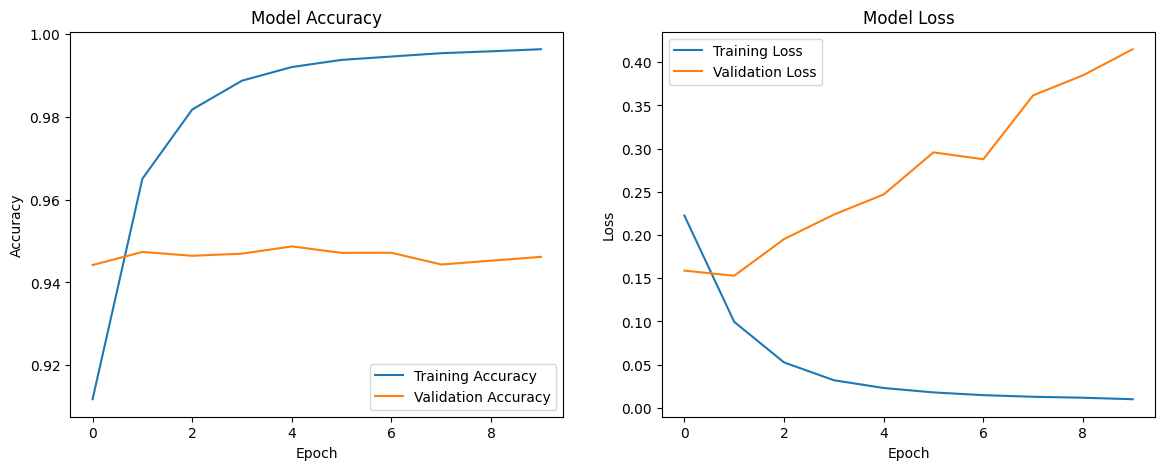

980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9462 - loss: 0.4137
Test Accuracy: 94.62%
3918/3918 ━━━━━━━━━━━━━━━━━━━━ 112s 28ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step
Accuracy: 0.9465
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     14237
           1       0.94      0.96      0.95     17105

    accuracy                           0.95     31342
   macro avg       0.95      0.95      0.95     31342
weighted avg       0.95      0.95      0.95     31342



In [14]:
split_ratio = 0.2

model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# Dropout = 0.6

/tmp/ipykernel_34/291186147.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Thought'] = self.df['Thought'].astype(str)
/tmp/ipykernel_34/291186147.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['Label'] = self.label_encoder.fit_transform(self.df['Label'])


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 600)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 600, 128)  │  4,862,592 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 596, 128)  │     82,048 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256)       │    263,168 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     49,280 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,257,217 (20.05 MB)

 Trainable params: 5,257,217 (20.05 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 168s 84ms/step - accuracy: 0.8547 - loss: 0.3162 - val_accuracy: 0.9408 - val_loss: 0.1618
Epoch 2/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 165s 84ms/step - accuracy: 0.9629 - loss: 0.1059 - val_accuracy: 0.9475 - val_loss: 0.1545
Epoch 3/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9821 - loss: 0.0522 - val_accuracy: 0.9451 - val_loss: 0.1811
Epoch 4/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9891 - loss: 0.0309 - val_accuracy: 0.9475 - val_loss: 0.2340
Epoch 5/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 83ms/step - accuracy: 0.9922 - loss: 0.0216 - val_accuracy: 0.9482 - val_loss: 0.2864
Epoch 6/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9935 - loss: 0.0171 - val_accuracy: 0.9493 - val_loss: 0.3061
Epoch 7/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 0.9952 - loss: 0.0139 - val_accuracy: 0.9475 - val_loss: 0.3197
Epoch 8/10
1959/1959 ━━━━━━━━━━━━━━━━━━━━ 164s 84ms/step - accuracy: 

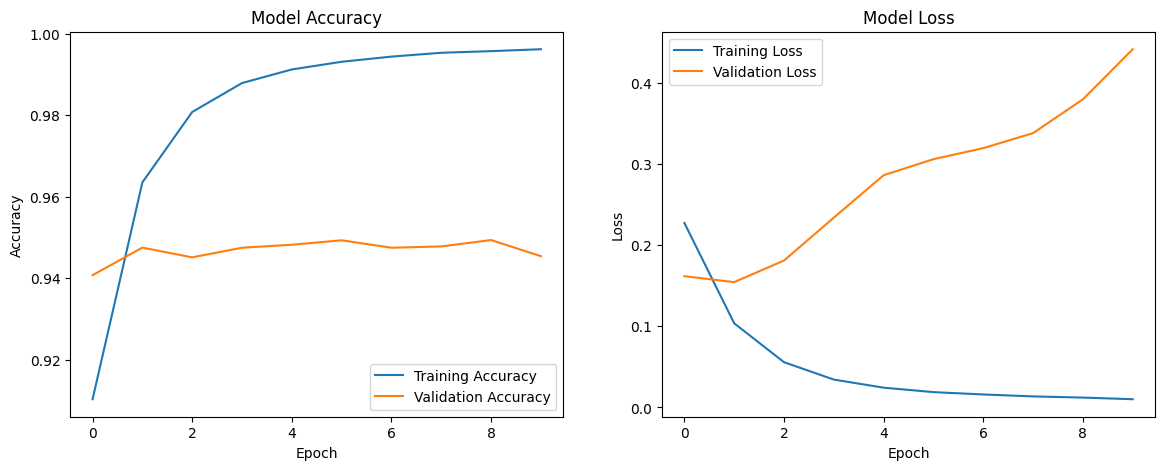

980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.9453 - loss: 0.4336
Test Accuracy: 94.54%
3918/3918 ━━━━━━━━━━━━━━━━━━━━ 111s 28ms/step
980/980 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step
Accuracy: 0.9454
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14237
           1       0.95      0.95      0.95     17105

    accuracy                           0.95     31342
   macro avg       0.95      0.94      0.94     31342
weighted avg       0.95      0.95      0.95     31342



In [16]:
split_ratio = 0.2
model_obj = TextClassificationModel(df)
X_train_pad, X_test_pad, y_train, y_test = model_obj.preprocess_data(split=split_ratio)
model = model_obj.build_model()
model.summary()
history = model_obj.train_model(model, X_train_pad, y_train, X_test_pad, y_test)
model_obj.plot_history(history)
model_obj.evaluate_model(model, X_test_pad, y_test)
X_train_features, X_test_features = model_obj.extract_features(model, X_train_pad, X_test_pad)
lr_model = model_obj.train_logistic_regression(X_train_features, y_train)
model_obj.evaluate_logistic_regression(lr_model, X_test_features, y_test)

# bar

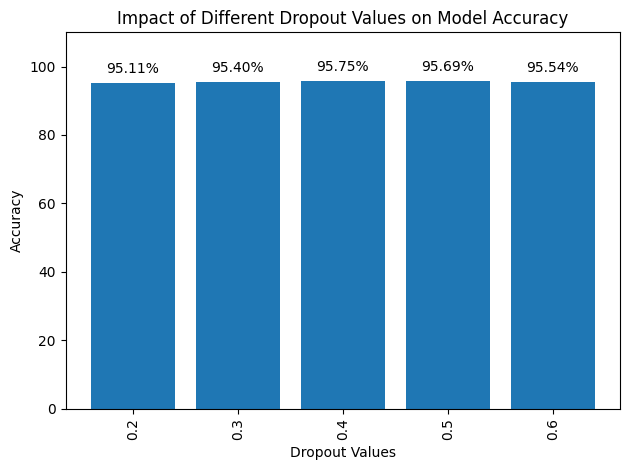

In [20]:
import matplotlib.pyplot as plt

models = ['0.2', '0.3', '0.4', '0.5', '0.6']
accuracies = [95.11, 95.40, 95.75, 95.69, 95.54]

plt.bar(models, accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Dropout Values')
plt.title(
    'Impact of Different Dropout Values on Model Accuracy'
)
plt.xticks(rotation='vertical')

# Display the accuracies at the top of each bar
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)
plt.ylim(0, 110)
plt.tight_layout()
plt.show()